# Plant Disease Classification with CNN and ResNet


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
train_dir = './Plant Disease Data/train'
test_dir = './Plant Disease Data/test'


Using device: cuda


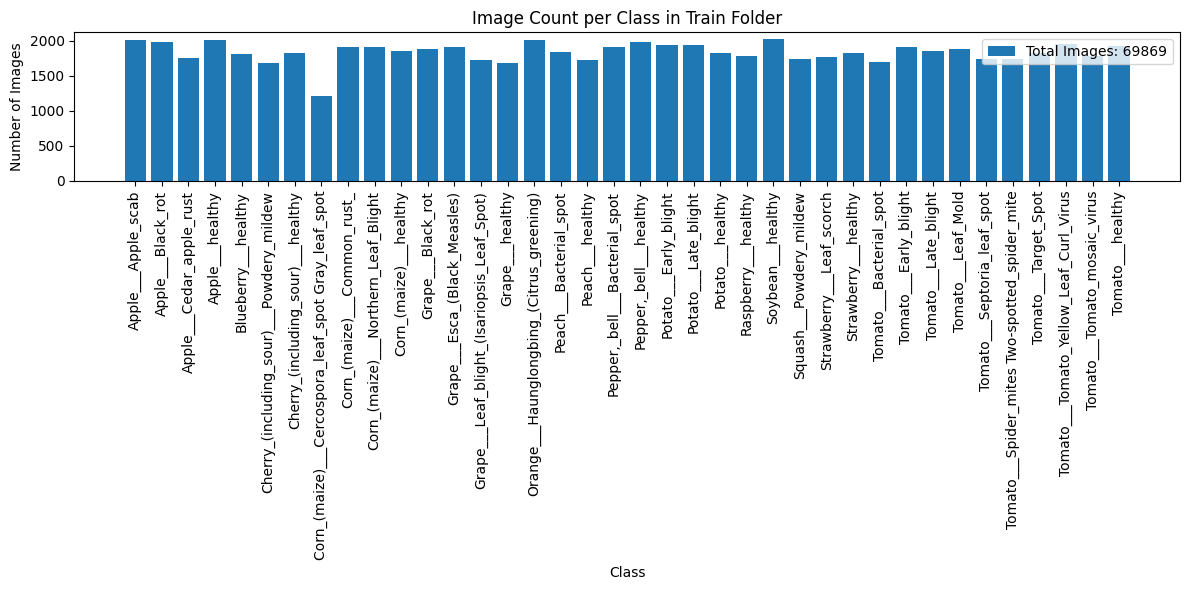

{'Apple___Apple_scab': 2016,
 'Apple___Black_rot': 1987,
 'Apple___Cedar_apple_rust': 1760,
 'Apple___healthy': 2008,
 'Blueberry___healthy': 1816,
 'Cherry_(including_sour)___Powdery_mildew': 1683,
 'Cherry_(including_sour)___healthy': 1826,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 1216,
 'Corn_(maize)___Common_rust_': 1907,
 'Corn_(maize)___Northern_Leaf_Blight': 1908,
 'Corn_(maize)___healthy': 1859,
 'Grape___Black_rot': 1888,
 'Grape___Esca_(Black_Measles)': 1920,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1722,
 'Grape___healthy': 1692,
 'Orange___Haunglongbing_(Citrus_greening)': 2010,
 'Peach___Bacterial_spot': 1838,
 'Peach___healthy': 1728,
 'Pepper,_bell___Bacterial_spot': 1913,
 'Pepper,_bell___healthy': 1988,
 'Potato___Early_blight': 1939,
 'Potato___Late_blight': 1939,
 'Potato___healthy': 1824,
 'Raspberry___healthy': 1781,
 'Soybean___healthy': 2022,
 'Squash___Powdery_mildew': 1736,
 'Strawberry___Leaf_scorch': 1774,
 'Strawberry___healthy': 1824,
 '

In [49]:

# Initialize a dictionary to store counts
class_counts = {}

# Walk through each class folder
for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif'))]
        class_counts[class_name] = len(images)

# Calculate total images
total_images = sum(class_counts.values())

# Plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Image Count per Class in Train Folder')

# Add total image count in legend
plt.legend([f"Total Images: {total_images}"], loc='upper right')

plt.tight_layout()
plt.show()

# Also show the counts dictionary
class_counts


In [29]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )
        self.flatten = nn.Flatten()
        # Adjust input size if image dimensions differ
        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.relu_fc1 = nn.ReLU()
        self.drop_fc1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = self.relu_fc1(x)
        x = self.drop_fc1(x)
        x = self.fc2(x)
        return x



In [30]:
class ResNetModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        # Freeze all layers
        for param in self.resnet.parameters():
            param.requires_grad = False
        # Fine-tune last layers
        for param in list(self.resnet.parameters())[-20:]:
            param.requires_grad = True
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

In [31]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)


class ResNetCustom(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.in_channels = 32

        # 1) conv1 + BN + ReLU
        self.conv1   = nn.Conv2d(3, 32, 3, stride=1, padding=1, bias=False)
        self.bn1     = nn.BatchNorm2d(32)
        self.relu    = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2, 2)

        # 2) four Residual stages (2 blocks each)
        self.layer1 = self._make_layer(32,  blocks=2, stride=1)  # 128→128
        self.layer2 = self._make_layer(64,  blocks=2, stride=2)  # 128→64
        self.layer3 = self._make_layer(128, blocks=2, stride=2)  # 64→32
        self.layer4 = self._make_layer(256, blocks=2, stride=2)  # 32→16

        # 3) classifier head: now 256×16×16 = 65 536 features
        self.flatten  = nn.Flatten()
        self.fc1      = nn.Linear(256 * 16 * 16, 512)
        self.bn_fc1   = nn.BatchNorm1d(512)
        self.relu_fc1 = nn.ReLU(inplace=True)
        self.drop_fc1 = nn.Dropout(0.5)
        self.fc2      = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = [ BasicBlock(self.in_channels, out_channels, stride, downsample) ]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)      # ← now 256→128
        x = self.layer1(x)       # 128→128
        x = self.layer2(x)       # 128→64
        x = self.layer3(x)       # 64→32
        x = self.layer4(x)       # 32→16
        x = self.flatten(x)      # 256×16×16 = 65536
        x = self.relu_fc1(self.bn_fc1(self.fc1(x)))
        x = self.drop_fc1(x)
        return self.fc2(x)


In [32]:
def count_trainable_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


/opt/Anaconda3-2023.03/envs/siu855621720@ad.siu.edu/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/Anaconda3-2023.03/envs/siu855621720@ad.siu.edu/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CustomCNN           : 34,749,638 trainable parameters
ResNetModel         : 9,993,766 trainable parameters
ResNetCustom        : 36,370,502 trainable parameters
ViTForClassfication : 57,520,934 trainable parameters


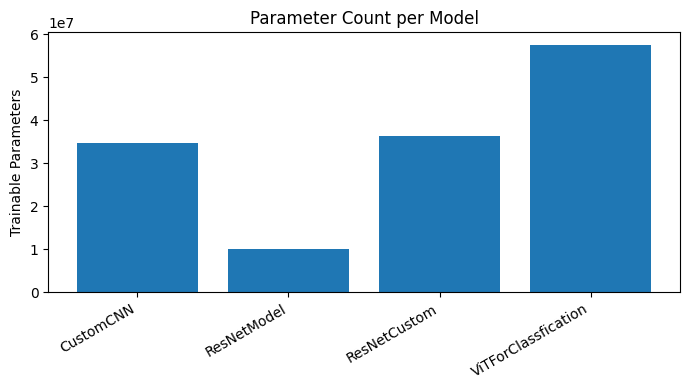

In [ ]:
model_dict = {
    "CustomCNN":    CustomCNN(num_classes=38),
    "ResNetModel":  ResNetModel(num_classes=38),
    "ResNetCustom": ResNetCustom(num_classes=38),
}


vit_params = 57520934


counts = {
    name: sum(p.numel() for p in m.parameters() if p.requires_grad)
    for name, m in model_dict.items()
}

# Add ViT into the same dict
counts["ViTForClassfication"] = vit_params

# Print them all
for name, c in counts.items():
    print(f"{name:20s}: {c:,} trainable parameters")

# Plot
plt.figure(figsize=(7,4))
plt.bar(counts.keys(), counts.values())
plt.ylabel("Trainable Parameters")
plt.title("Parameter Count per Model")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()



In [ ]:
from torchvision import datasets, transforms

loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(train_dir, transform=transforms.ToTensor()),
    batch_size=64, shuffle=False, num_workers=4)

cnt = 0
s1 = torch.zeros(3)
s2 = torch.zeros(3)
for imgs, _ in loader:
    cnt += imgs.size(0)*imgs.size(2)*imgs.size(3)
    s1  += imgs.sum(dim=[0,2,3])
    s2  += (imgs**2).sum(dim=[0,2,3])
mean = s1/cnt
std  = (s2/cnt - mean**2).sqrt()


In [47]:
print(mean)
print(std)

tensor([0.4762, 0.5006, 0.4270])
tensor([0.2163, 0.1954, 0.2320])


In [ ]:

batch_size=32
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4762, 0.5006, 0.4270],
                                 std =[0.2163, 0.1954, 0.2320])
])

train_dataset = ImageFolder(train_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")


Found 38 classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', '

In [35]:
def save_model_and_epoch(model, epoch, model_name, save_dir,
                         train_loss=None, test_loss=None, test_acc=None):
    """
    Saves model state, updates epoch info, and logs metrics (if provided)
    into <save_dir>/<model_name>_metrics.json.
    """
    os.makedirs(save_dir, exist_ok=True)

    # 1) save model weights
    model_path = os.path.join(save_dir, f"{model_name}_epoch_{epoch+1}.pth")
    torch.save(model.state_dict(), model_path)

    # 2) update epoch info
    info_path = os.path.join(save_dir, f"{model_name}_epoch_info.json")
    with open(info_path, 'w') as f:
        json.dump({"epoch": epoch+1}, f)

    # 3) update metrics.json
    metrics_path = os.path.join(save_dir, f"{model_name}_metrics.json")
    if os.path.exists(metrics_path):
        with open(metrics_path) as f:
            metrics = json.load(f)
    else:
        # initialize lists
        metrics = {
            "epoch": [],
            "train_loss": [],
            "test_loss": [],
            "test_acc": []
        }

    metrics["epoch"].append(epoch+1)
    if train_loss  is not None: metrics["train_loss"].append(train_loss)
    if test_loss   is not None: metrics["test_loss"].append(test_loss)
    if test_acc    is not None: metrics["test_acc"].append(test_acc)

    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)

    print(f"Saved {model_name} at epoch {epoch+1}")

def load_checkpoint(model, model_name, save_dir):
    """
    Loads the last saved epoch into model and returns that epoch number (0 if none).
    """
    info_path = os.path.join(save_dir, f"{model_name}_epoch_info.json")
    if os.path.exists(info_path):
        with open(info_path) as f:
            info = json.load(f)
        ckpt_path = os.path.join(save_dir, f"{model_name}_epoch_{info['epoch']}.pth")
        model.load_state_dict(torch.load(ckpt_path, map_location=device))
        print(f"Loaded {model_name} from epoch {info['epoch']}")
        return info['epoch']
    return 0

def test_model(model, loader, criterion):
    """
    Evaluates model on loader, returning (test_loss, test_acc%).
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_loss = running_loss / total
    test_acc  = 100.0 * correct / total
    return test_loss, test_acc


In [36]:
# Start training all models
cnn_save_dir = r'/home/siu855621720/Plant Disease Project/code/Cnn Resnet/cnn_checkpoints'
resnet_save_dir = r'/home/siu855621720/Plant Disease Project/code/Cnn Resnet/resnet_checkpoints'
resnet_custom_save_dir = r'/home/siu855621720/Plant Disease Project/code/Cnn Resnet/resnet_custom_checkpoints'

In [37]:
# Instantiate models, criterion, and optimizers

cnn_model = CustomCNN(num_classes).to(device)
resnet_model = ResNetModel(num_classes).to(device)
resnet_custom_model = ResNetCustom(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=1e-3)
optimizer_resnet = optim.Adam(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=1e-4)
optimizer_resnet_custom = optim.Adam(resnet_custom_model.parameters(), lr=1e-4)

In [38]:
def train_model(model, optimizer, save_dir, model_name, epochs=10):
    # resume from last epoch if exists
    start_epoch = load_checkpoint(model, model_name, save_dir)

    for epoch in range(start_epoch, epochs):
        model.train()
        running_loss = 0.0

        # --- TRAIN STEP ---
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # average train loss per batch
        train_loss = running_loss / len(train_loader)

        # --- EVAL STEP ---
        test_loss, test_acc = test_model(model, test_loader, criterion)

        # --- SAVE CHECKPOINT + METRICS ---
        save_model_and_epoch(
            model, epoch, model_name, save_dir,
            train_loss=train_loss,
            test_loss=test_loss,
            test_acc=test_acc
        )


In [ ]:


train_model(cnn_model, optimizer_cnn, cnn_save_dir, 'cnn_model', epochs=20)
train_model(resnet_model, optimizer_resnet, resnet_save_dir, 'resnet_model', epochs=20)
train_model(resnet_custom_model, optimizer_resnet_custom, resnet_custom_save_dir, 'resnet_custom_model', epochs=20)


cnn_model Epoch [1/20]  Train Loss: 0.7565  Test Loss: 0.2553  Test Acc: 92.07%
Saved cnn_model at epoch 1
cnn_model Epoch [2/20]  Train Loss: 0.2977  Test Loss: 0.2814  Test Acc: 91.15%
Saved cnn_model at epoch 2
cnn_model Epoch [3/20]  Train Loss: 0.2036  Test Loss: 0.1538  Test Acc: 94.82%
Saved cnn_model at epoch 3
cnn_model Epoch [4/20]  Train Loss: 0.1552  Test Loss: 0.1222  Test Acc: 95.82%
Saved cnn_model at epoch 4
cnn_model Epoch [5/20]  Train Loss: 0.1225  Test Loss: 0.0855  Test Acc: 97.09%
Saved cnn_model at epoch 5
cnn_model Epoch [6/20]  Train Loss: 0.0984  Test Loss: 0.0653  Test Acc: 97.83%
Saved cnn_model at epoch 6
cnn_model Epoch [7/20]  Train Loss: 0.0826  Test Loss: 0.0671  Test Acc: 97.69%
Saved cnn_model at epoch 7


In [ ]:
normalize = transforms.Normalize(mean=[0.4762, 0.5006, 0.4270],
                                 std =[0.2163, 0.1954, 0.2320])

test_tf = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    normalize,
])

# Build test loader
test_dataset = ImageFolder(test_dir, transform=test_tf)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Evaluate each saved model on the test set
criterion = nn.CrossEntropyLoss()

for model_name, ModelClass, save_dir in [
    ('cnn_model',           CustomCNN,       cnn_save_dir),
    ('resnet_model',        ResNetModel,     resnet_save_dir),
    ('resnet_custom_model', ResNetCustom,    resnet_custom_save_dir),
]:
    model = ModelClass(num_classes).to(device)
    last_epoch = load_checkpoint(model, model_name, save_dir)
    test_loss, test_acc = test_model(model, test_loader, criterion)
    print(f"{model_name}:  "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")




Loaded cnn_model from epoch 20
cnn_model:  Test Loss: 0.0336, Test Accuracy: 98.99%
Loaded resnet_model from epoch 20
resnet_model:  Test Loss: 0.0165, Test Accuracy: 99.57%
Loaded resnet_custom_model from epoch 20
resnet_custom_model:  Test Loss: 0.0324, Test Accuracy: 98.93%


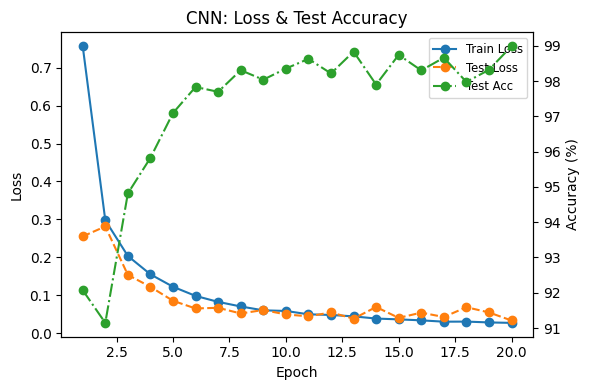

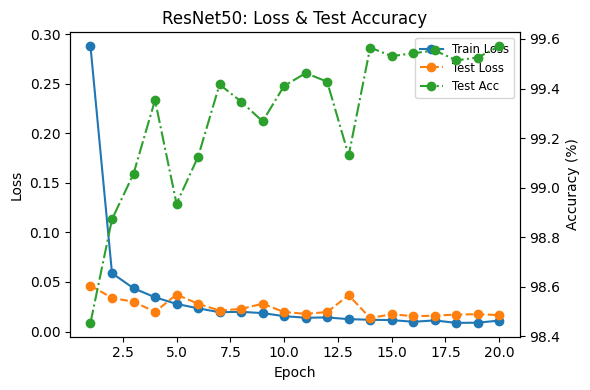

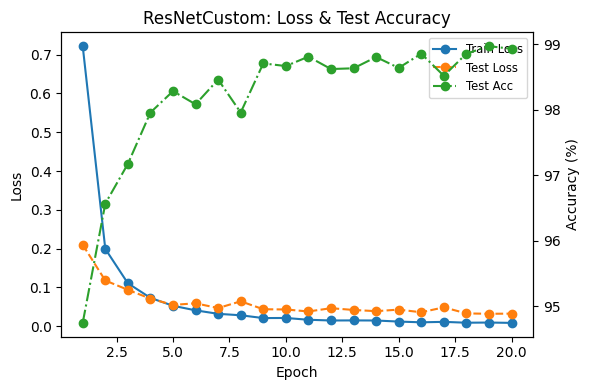

In [40]:
models_info = [
    ("CNN",           "cnn_model",           cnn_save_dir),
    ("ResNet50",      "resnet_model",        resnet_save_dir),
    ("ResNetCustom",  "resnet_custom_model", resnet_custom_save_dir),
]

for display_name, model_name, save_dir in models_info:
    metrics_path = os.path.join(save_dir, f"{model_name}_metrics.json")
    if not os.path.exists(metrics_path):
        print(f"[WARN] Missing metrics for {display_name}")
        continue

    # Load metrics
    with open(metrics_path) as f:
        m = json.load(f)

    epochs     = m["epoch"]
    train_loss = m.get("train_loss", [])
    test_loss  = m.get("test_loss", [])
    test_acc   = m.get("test_acc", [])

    # Plot
    fig, ax1 = plt.subplots(figsize=(6,4))

    # Plot train & test loss on left y-axis
    ax1.plot(epochs, train_loss, label="Train Loss",   linestyle='-', marker='o')
    ax1.plot(epochs, test_loss,  label="Test Loss",    linestyle='--', marker='o')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.tick_params(axis='y')
    
    # Plot test accuracy on right y-axis
    ax2 = ax1.twinx()
    ax2.plot(epochs, test_acc,   label="Test Acc",     color='tab:green', linestyle='-.', marker='o')
    ax2.set_ylabel("Accuracy (%)")
    ax2.tick_params(axis='y')

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize='small')

    plt.title(f"{display_name}: Loss & Test Accuracy")
    plt.tight_layout()
    plt.show()


Accuracy (overall) : 0.990
Weighted Avg Precision : 0.990
Weighted Avg Recall    : 0.990
Weighted Avg F1-Score  : 0.990


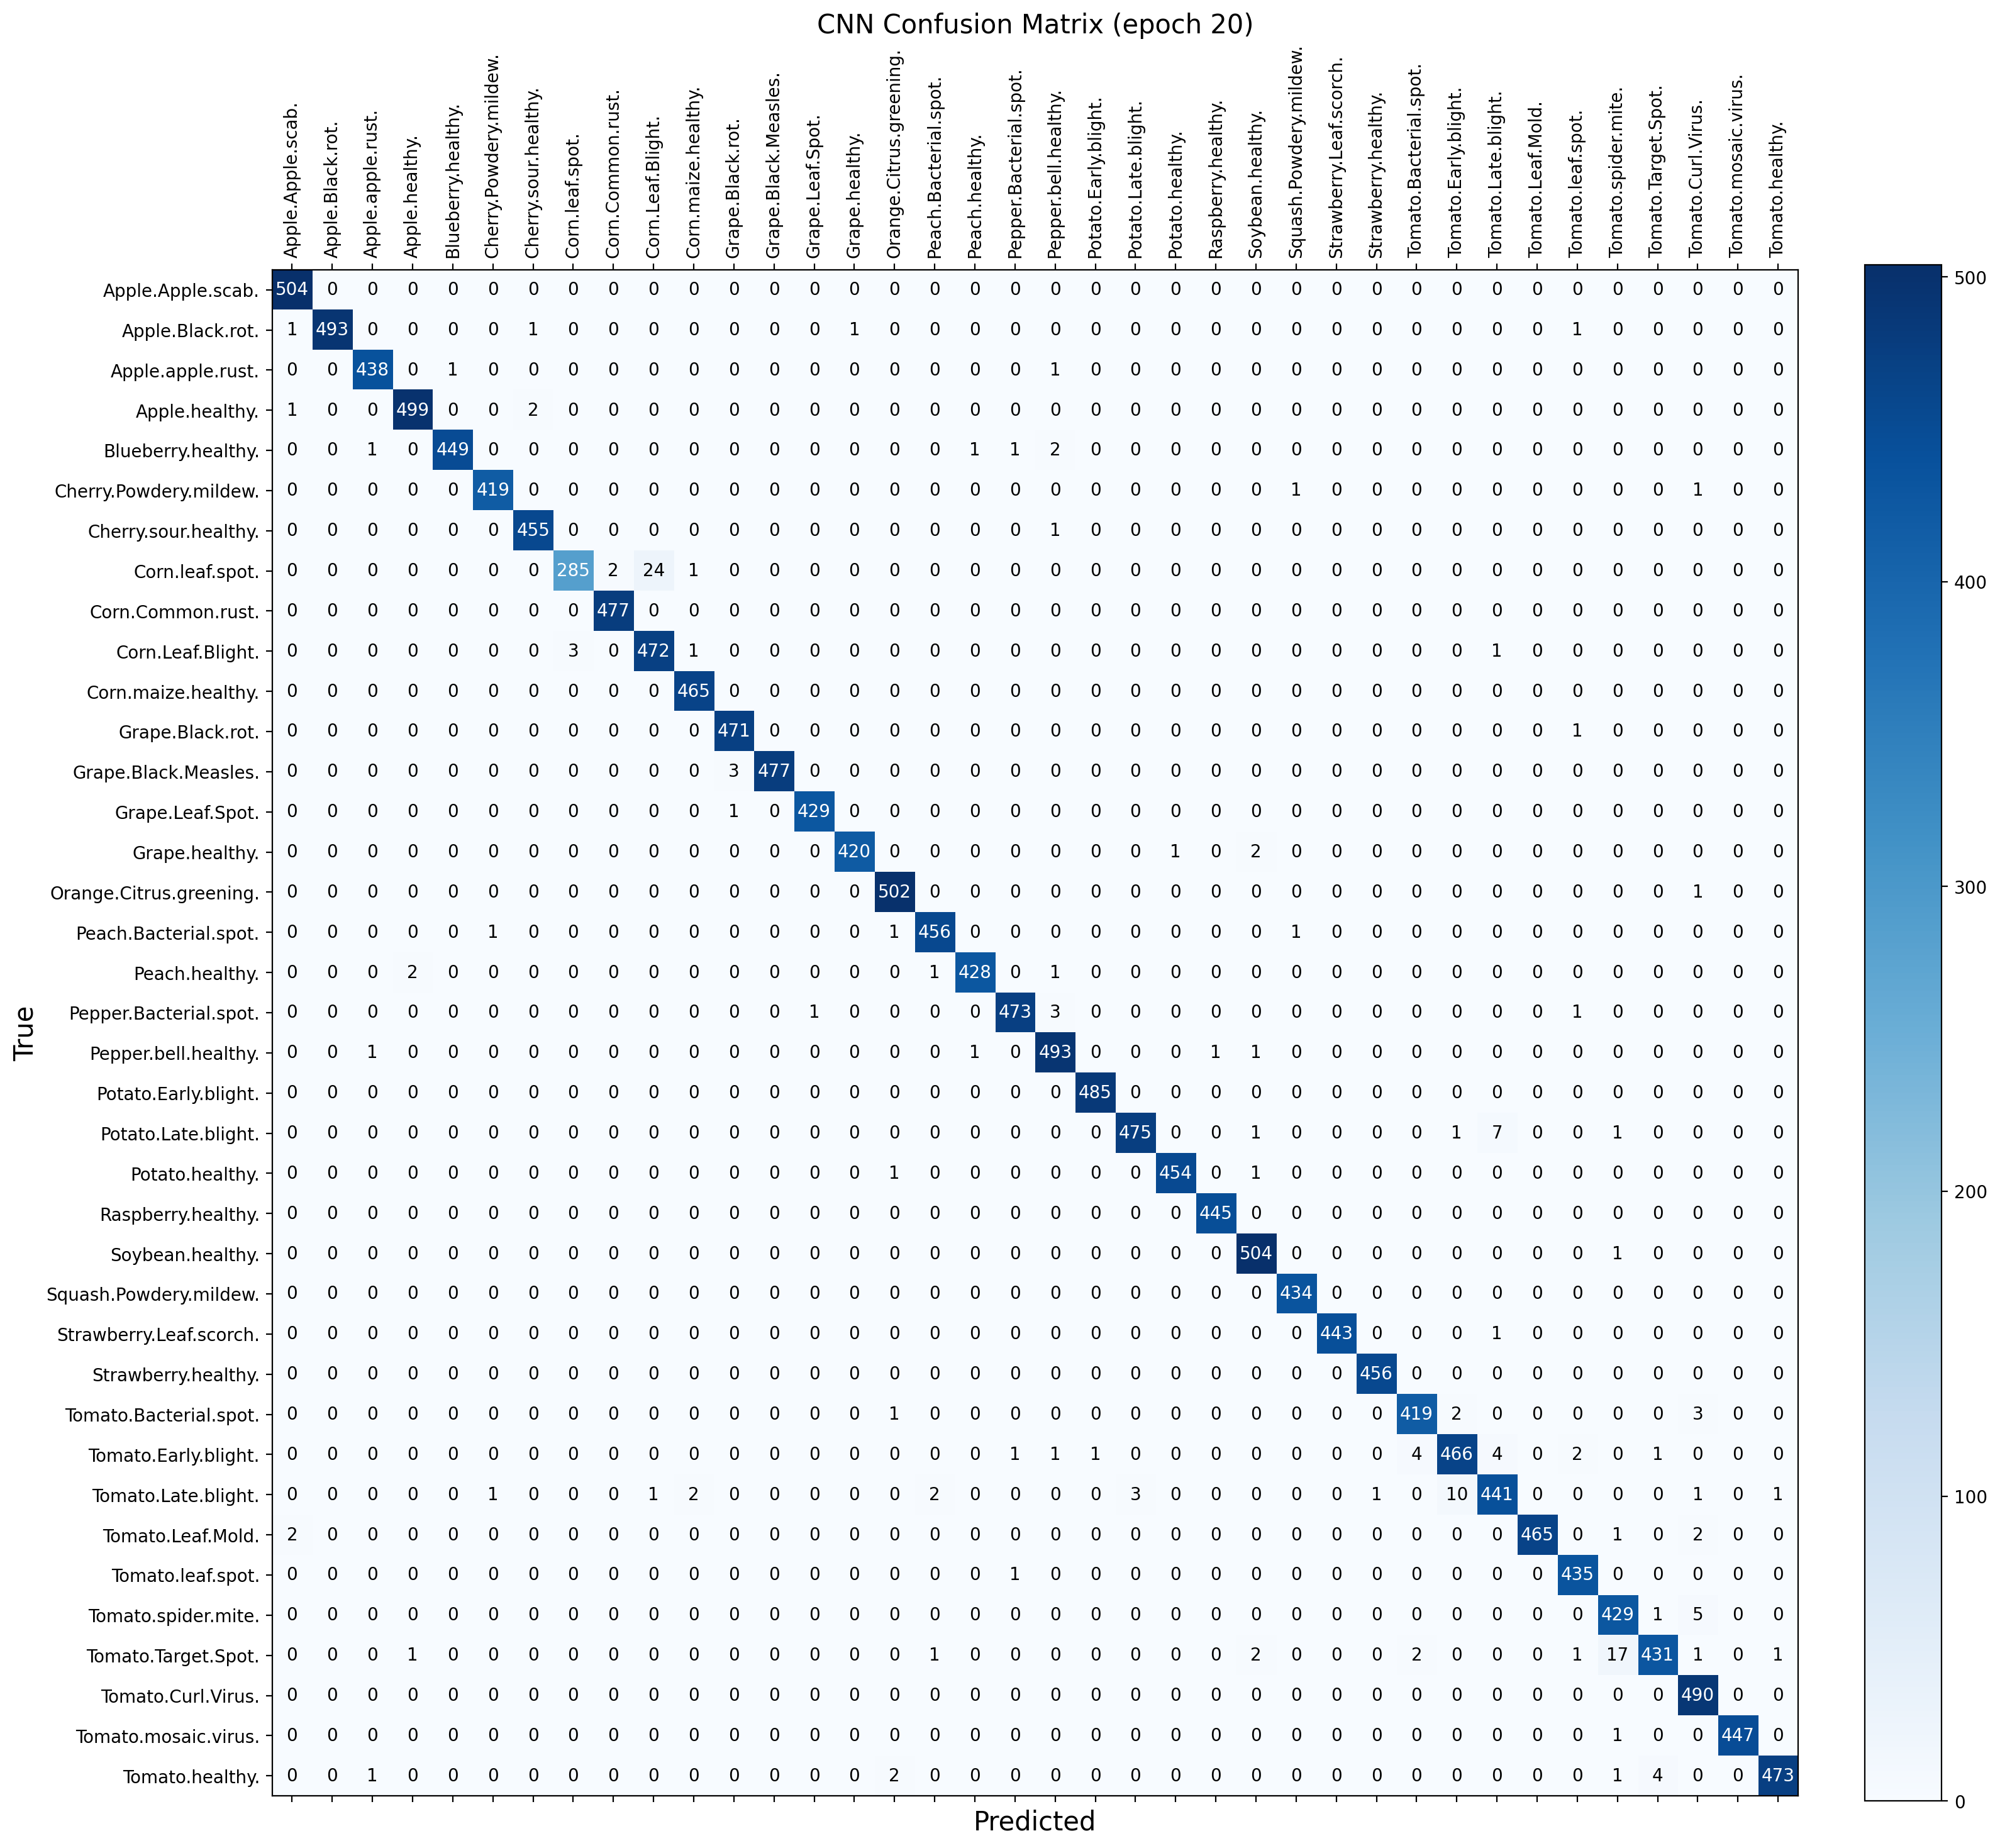

/opt/Anaconda3-2023.03/envs/siu855621720@ad.siu.edu/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/Anaconda3-2023.03/envs/siu855621720@ad.siu.edu/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy (overall) : 0.996
Weighted Avg Precision : 0.996
Weighted Avg Recall    : 0.996
Weighted Avg F1-Score  : 0.996


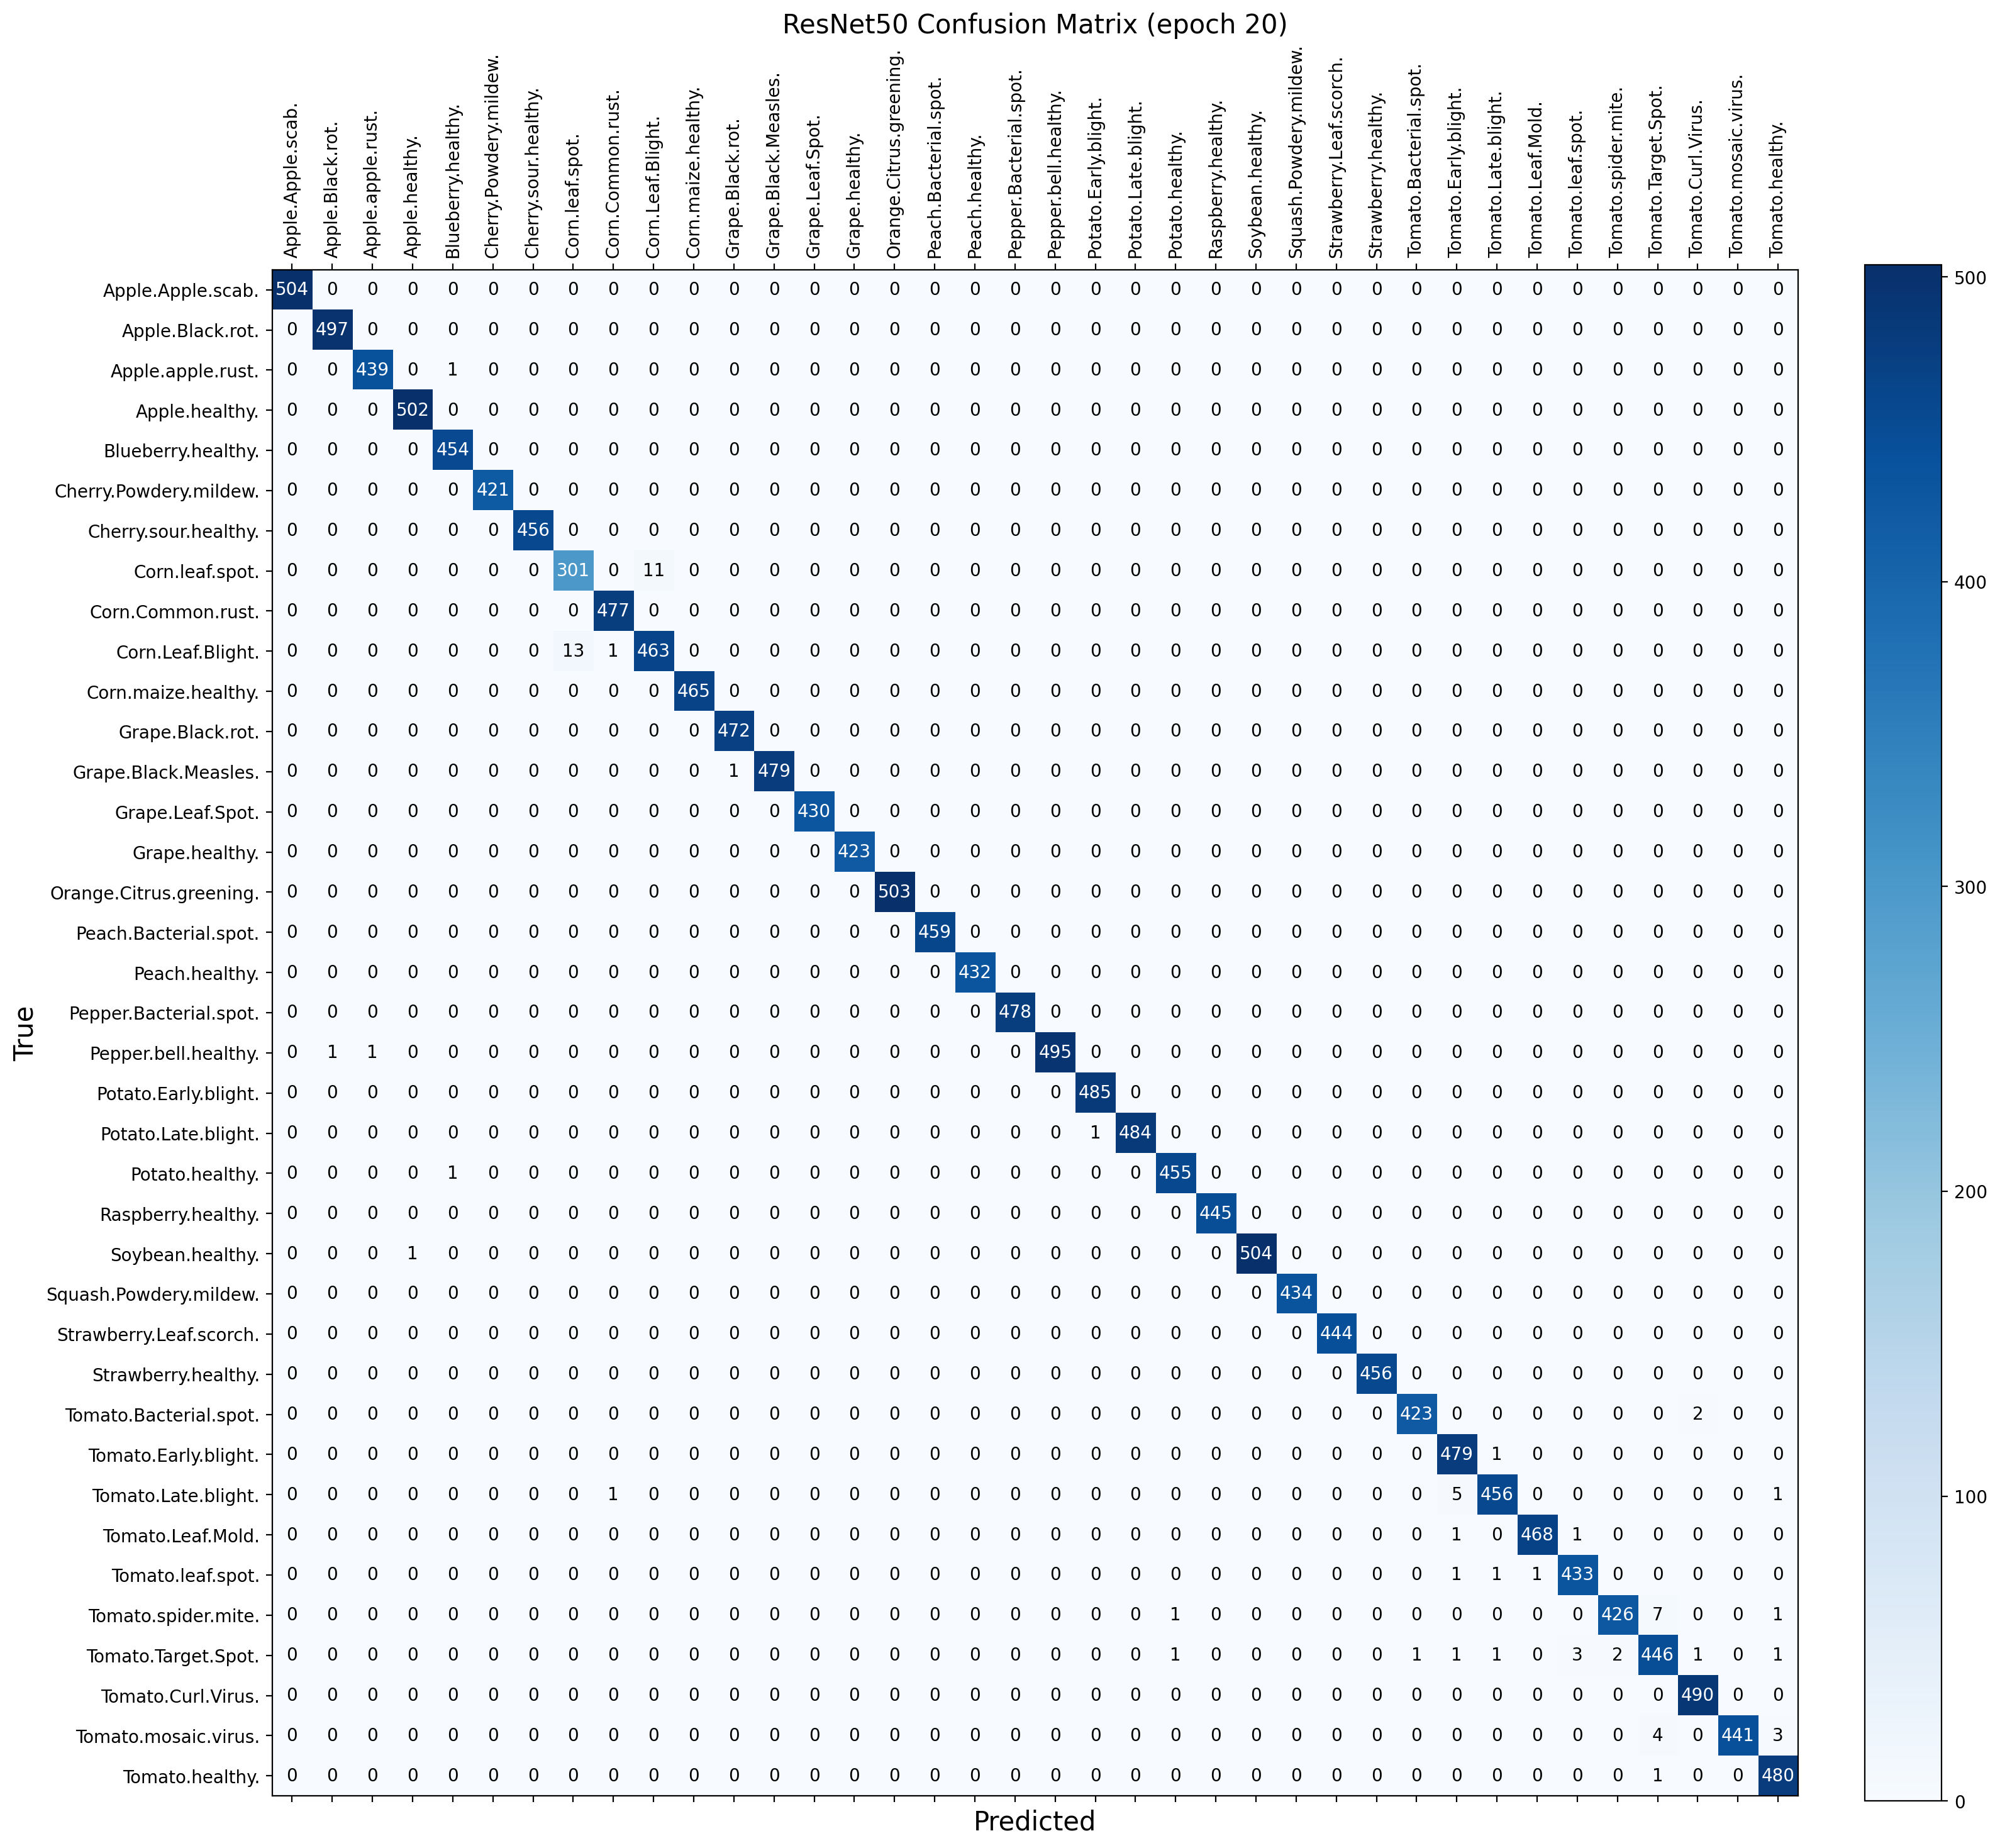

Accuracy (overall) : 0.989
Weighted Avg Precision : 0.989
Weighted Avg Recall    : 0.989
Weighted Avg F1-Score  : 0.989


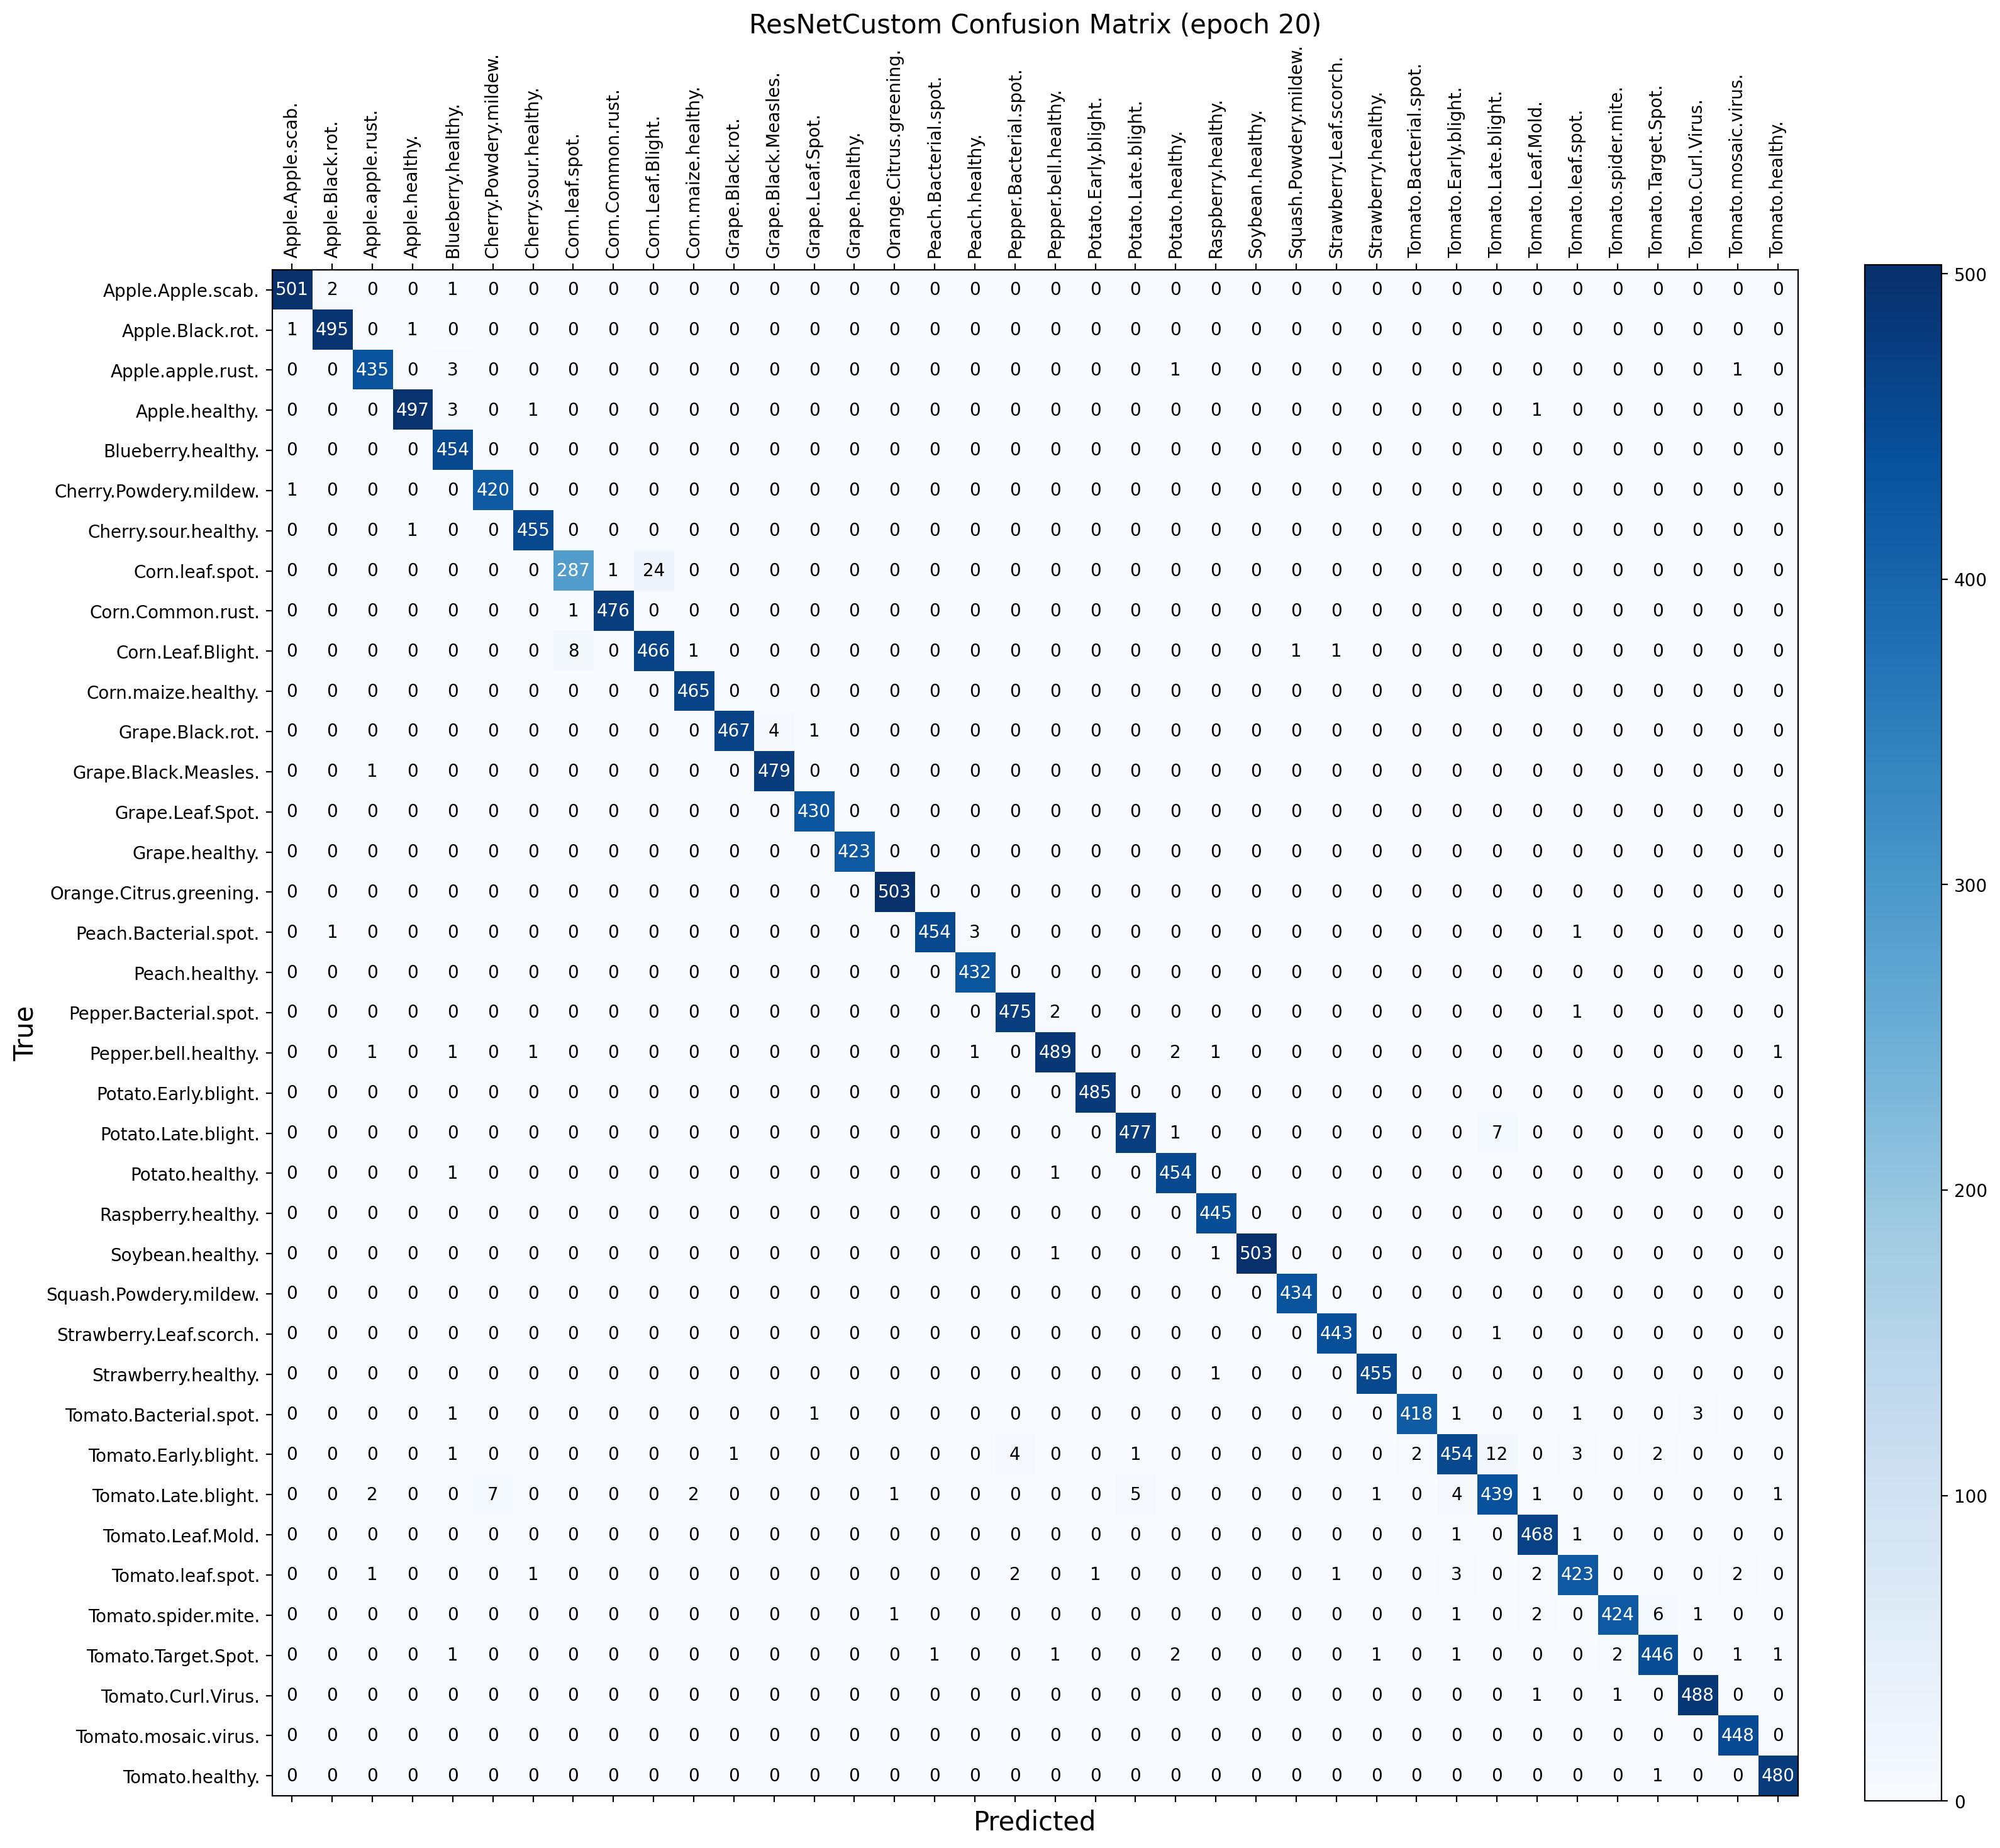

In [ ]:
import os, glob
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_tf  = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.4762, 0.5006, 0.4270],[0.2163, 0.1954, 0.2320])
])
ds     = ImageFolder(test_dir, transform=test_tf)
loader = DataLoader(ds, batch_size=32, shuffle=False, num_workers=4)
classes = ds.classes
n_cls   = len(classes)


import re

def abbreviate(name):
    
   
    cleaned = re.sub(r'[^A-Za-z0-9_\s]', '', name)
    # split on underscores or whitespace
    parts = [p for p in re.split(r'[_\s]+', cleaned) if p]
    if not parts:
        return ''
    first = parts[0]
    
    # pick the last two parts (if available)
    if len(parts) >= 3:
        last_two = parts[-2:]
    elif len(parts) == 2:
        last_two = [parts[-1]]
    else:
        last_two = []
    
    # build the abbreviation
    abbr = first
    for w in last_two:
        abbr += f".{w}"
    abbr += "."
    return abbr

short_labels = [abbreviate(c) for c in classes]

# Models & checkpoint dirs
models_info = [
    (
        'CNN',
        CustomCNN,
        'cnn_model',
        '/home/siu855621720/Plant Disease Project/code/Cnn Resnet/cnn_checkpoints'
    ),
    (
        'ResNet50',
        ResNetModel,
        'resnet_model',
        '/home/siu855621720/Plant Disease Project/code/Cnn Resnet/resnet_checkpoints'
    ),
    (
        'ResNetCustom',
        ResNetCustom,
        'resnet_custom_model',
        '/home/siu855621720/Plant Disease Project/code/Cnn Resnet/resnet_custom_checkpoints'
    ),
]

# Loop and plot
for title, ModelClass, base_name, save_dir in models_info:
    # find all .pth files
    pths = glob.glob(os.path.join(save_dir, f"{base_name}_epoch_*.pth"))
    if not pths:
        print(f"[WARN] no checkpoints found in {save_dir}")
        continue

    # extract (epoch, path) pairs
    epoch_files = []
    for p in pths:
        fname = os.path.basename(p)
        # e.g. 'resnet_model_epoch_12.pth'
        parts = fname.split('_')
        try:
            ep = int(parts[-1].split('.')[0])
            epoch_files.append((ep, p))
        except:
            continue

    if not epoch_files:
        print(f"[WARN] no parsable checkpoint names in {save_dir}")
        continue

    best_ep, best_path = max(epoch_files, key=lambda x: x[0])

    # load model
    model = ModelClass(n_cls).to(device)
    model.load_state_dict(torch.load(best_path, map_location=device))
    model.eval()

    # collect preds
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            out  = model(imgs)
            preds = out.argmax(dim=1).cpu().numpy()
            y_true.extend(labels.numpy())
            y_pred.extend(preds)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_cls))
    cls_rpt = classification_report(y_true, y_pred, target_names=classes,output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)
    weighted = cls_rpt["weighted avg"]
    
    print(f"Accuracy (overall) : {accuracy:.3f}")
    print(f"Weighted Avg Precision : {weighted['precision']:.3f}")
    print(f"Weighted Avg Recall    : {weighted['recall']:.3f}")
    print(f"Weighted Avg F1-Score  : {weighted['f1-score']:.3f}")
    # plot hi-res
    fig, ax = plt.subplots(figsize=(16,16), dpi=200)
    im = ax.matshow(cm, cmap='Blues')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_xticks(np.arange(n_cls))
    ax.set_yticks(np.arange(n_cls))
    ax.set_xticklabels(short_labels, rotation=90, fontsize=10)
    ax.set_yticklabels(short_labels, rotation=0, fontsize=10)
    ax.set_xlabel('Predicted', fontsize=15)
    ax.set_ylabel('True',      fontsize=15)
    ax.set_title(f'{title} Confusion Matrix (epoch {best_ep})', fontsize=15)

    # annotate
    thresh = cm.max() / 2
    for i in range(n_cls):
        for j in range(n_cls):
            color = 'white' if cm[i,j] > thresh else 'black'
            ax.text(j, i, cm[i,j], ha='center', va='center', color=color, fontsize=10)

    plt.tight_layout()
    plt.show()
